<div style="background-color: #eeffee; border-color: #bbFFbb; border-left: 5px solid #88FF88; padding: 0.5em;">
Realizamos todos los import necesarios.
</div>

In [1]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import defaultdict
from nltk.corpus import stopwords
import re 
import treetaggerwrapper

<div style="background-color: #eeffee; border-color: #bbFFbb; border-left: 5px solid #88FF88; padding: 0.5em;">
Cargamos los datasets.
</div>

In [2]:
domo_dataset = sqlContext.read.parquet("dataset/domo_dataset.parquet")
label_dataset = sqlContext.read.csv("dataset/20190802_meta_todo.csv", header=True)
print(domo_dataset)
print(label_dataset)
label_dataset.show(5, False)

DataFrame[co_llamada_verint: string, id_descarga: string, nu_telefono_actuacion: string, it_llamada: timestamp, nu_llamada_ic: string, co_grabacion: string, in_poc1: boolean, satisfaccion: double, in_softskills: boolean, con_ventasbrutas: boolean, con_ventasbrutas_positiva: boolean, con_moni: boolean, con_trans: boolean, raw_bison: array<string>, n_sentences_bison: double, raw_verint: array<string>, n_sentences_verint: double, raw_bison_sanitized: array<string>, raw_verint_sanitized: array<string>, __index_level_0__: bigint]
DataFrame[co_llamada_verint: string, nu_telefono_actuacion: string, it_llamada: string, nu_llamada_ic: string, co_grabacion: string, no_destino_pa: string, in_poc1: string, satisfaccion: string, in_softskills: string, con_ventasbrutas: string, con_ventasbrutas_positiva: string, con_moni: string, con_trans: string, ucid: string]
+-------------------+---------------------+--------------------+-----------------+------------+--------------------------+-------+---------

<div style="background-color: #eeffee; border-color: #bbFFbb; border-left: 5px solid #88FF88; padding: 0.5em;">
Vemos todas las etiquetas disponibles. 
</div>

In [3]:
label_dataset.createOrReplaceTempView("label_tmp")
labels = sqlContext.sql("SELECT DISTINCT no_destino_pa FROM label_tmp")
labels.show(500, False)

+-------------------------------------------------+
|no_destino_pa                                    |
+-------------------------------------------------+
|IVR-ASVRU                                        |
|MovistarTV_ConectividadTVSAT                     |
|TOL_NoCol                                        |
|Baja_OtrosProductosServicios                     |
|Averia_Telefono_AdminKO                          |
|LlamadasInternacionales                          |
|DesvioLlamadas_Incidencia_AdminKO                |
|MovistarTV_Futbol                                |
|Provision_Desambig                               |
|Internet_NoCol                                   |
|AT_Fijo_Voz                                      |
|IVR-DeudaF                                       |
|MovistarTV_Dispositivo_Desambig                  |
|Comercial_MovistarTV                             |
|Contratacion_Extra                               |
|CAOL ESTE CAOL                                   |
|DesvioLlama

<div style="background-color: #eeffee; border-color: #bbFFbb; border-left: 5px solid #88FF88; padding: 0.5em;">
Vemos las llamadas etiquetadas disponibles. 
</div>

In [4]:
domo_dataset.createOrReplaceTempView("domo_tmp")
label_calls = sqlContext.sql("""SELECT a.co_llamada_verint,a.raw_verint, b.no_destino_pa 
                                FROM domo_tmp a JOIN label_tmp b
                                ON a.co_llamada_verint = b.co_llamada_verint
                                WHERE a.raw_verint IS NOT NULL""")

label_calls.cache()
print('Llamadas etiquetadas disponibles : {:,}'.format( label_calls.count()))  


Llamadas etiquetadas disponibles : 170,844


In [5]:
label_calls.show(10, False)

+-------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [6]:
etiquetas_manuales = [ ("9133993310370003051", ["consultar", "tarifa", "mínima", "bajar", "económico","cambio", "pagaría", "segunda", "línea", "portar", "promoción", "navegación", "minutos", "compromiso", "permanencia"], "Tarifas_Cambiar" 
                       
                )
    ]

In [7]:
label_calls.createOrReplaceTempView("label_tmp")

label_dist = sqlContext.sql("""SELECT no_destino_pa , COUNT(*) as num_calls
                                FROM domo_tmp a JOIN label_tmp b
                                ON a.co_llamada_verint = b.co_llamada_verint
                                WHERE a.raw_verint IS NOT NULL
                                GROUP BY no_destino_pa""").rdd.map(lambda x: (x["no_destino_pa"], x["num_calls"])).collect()


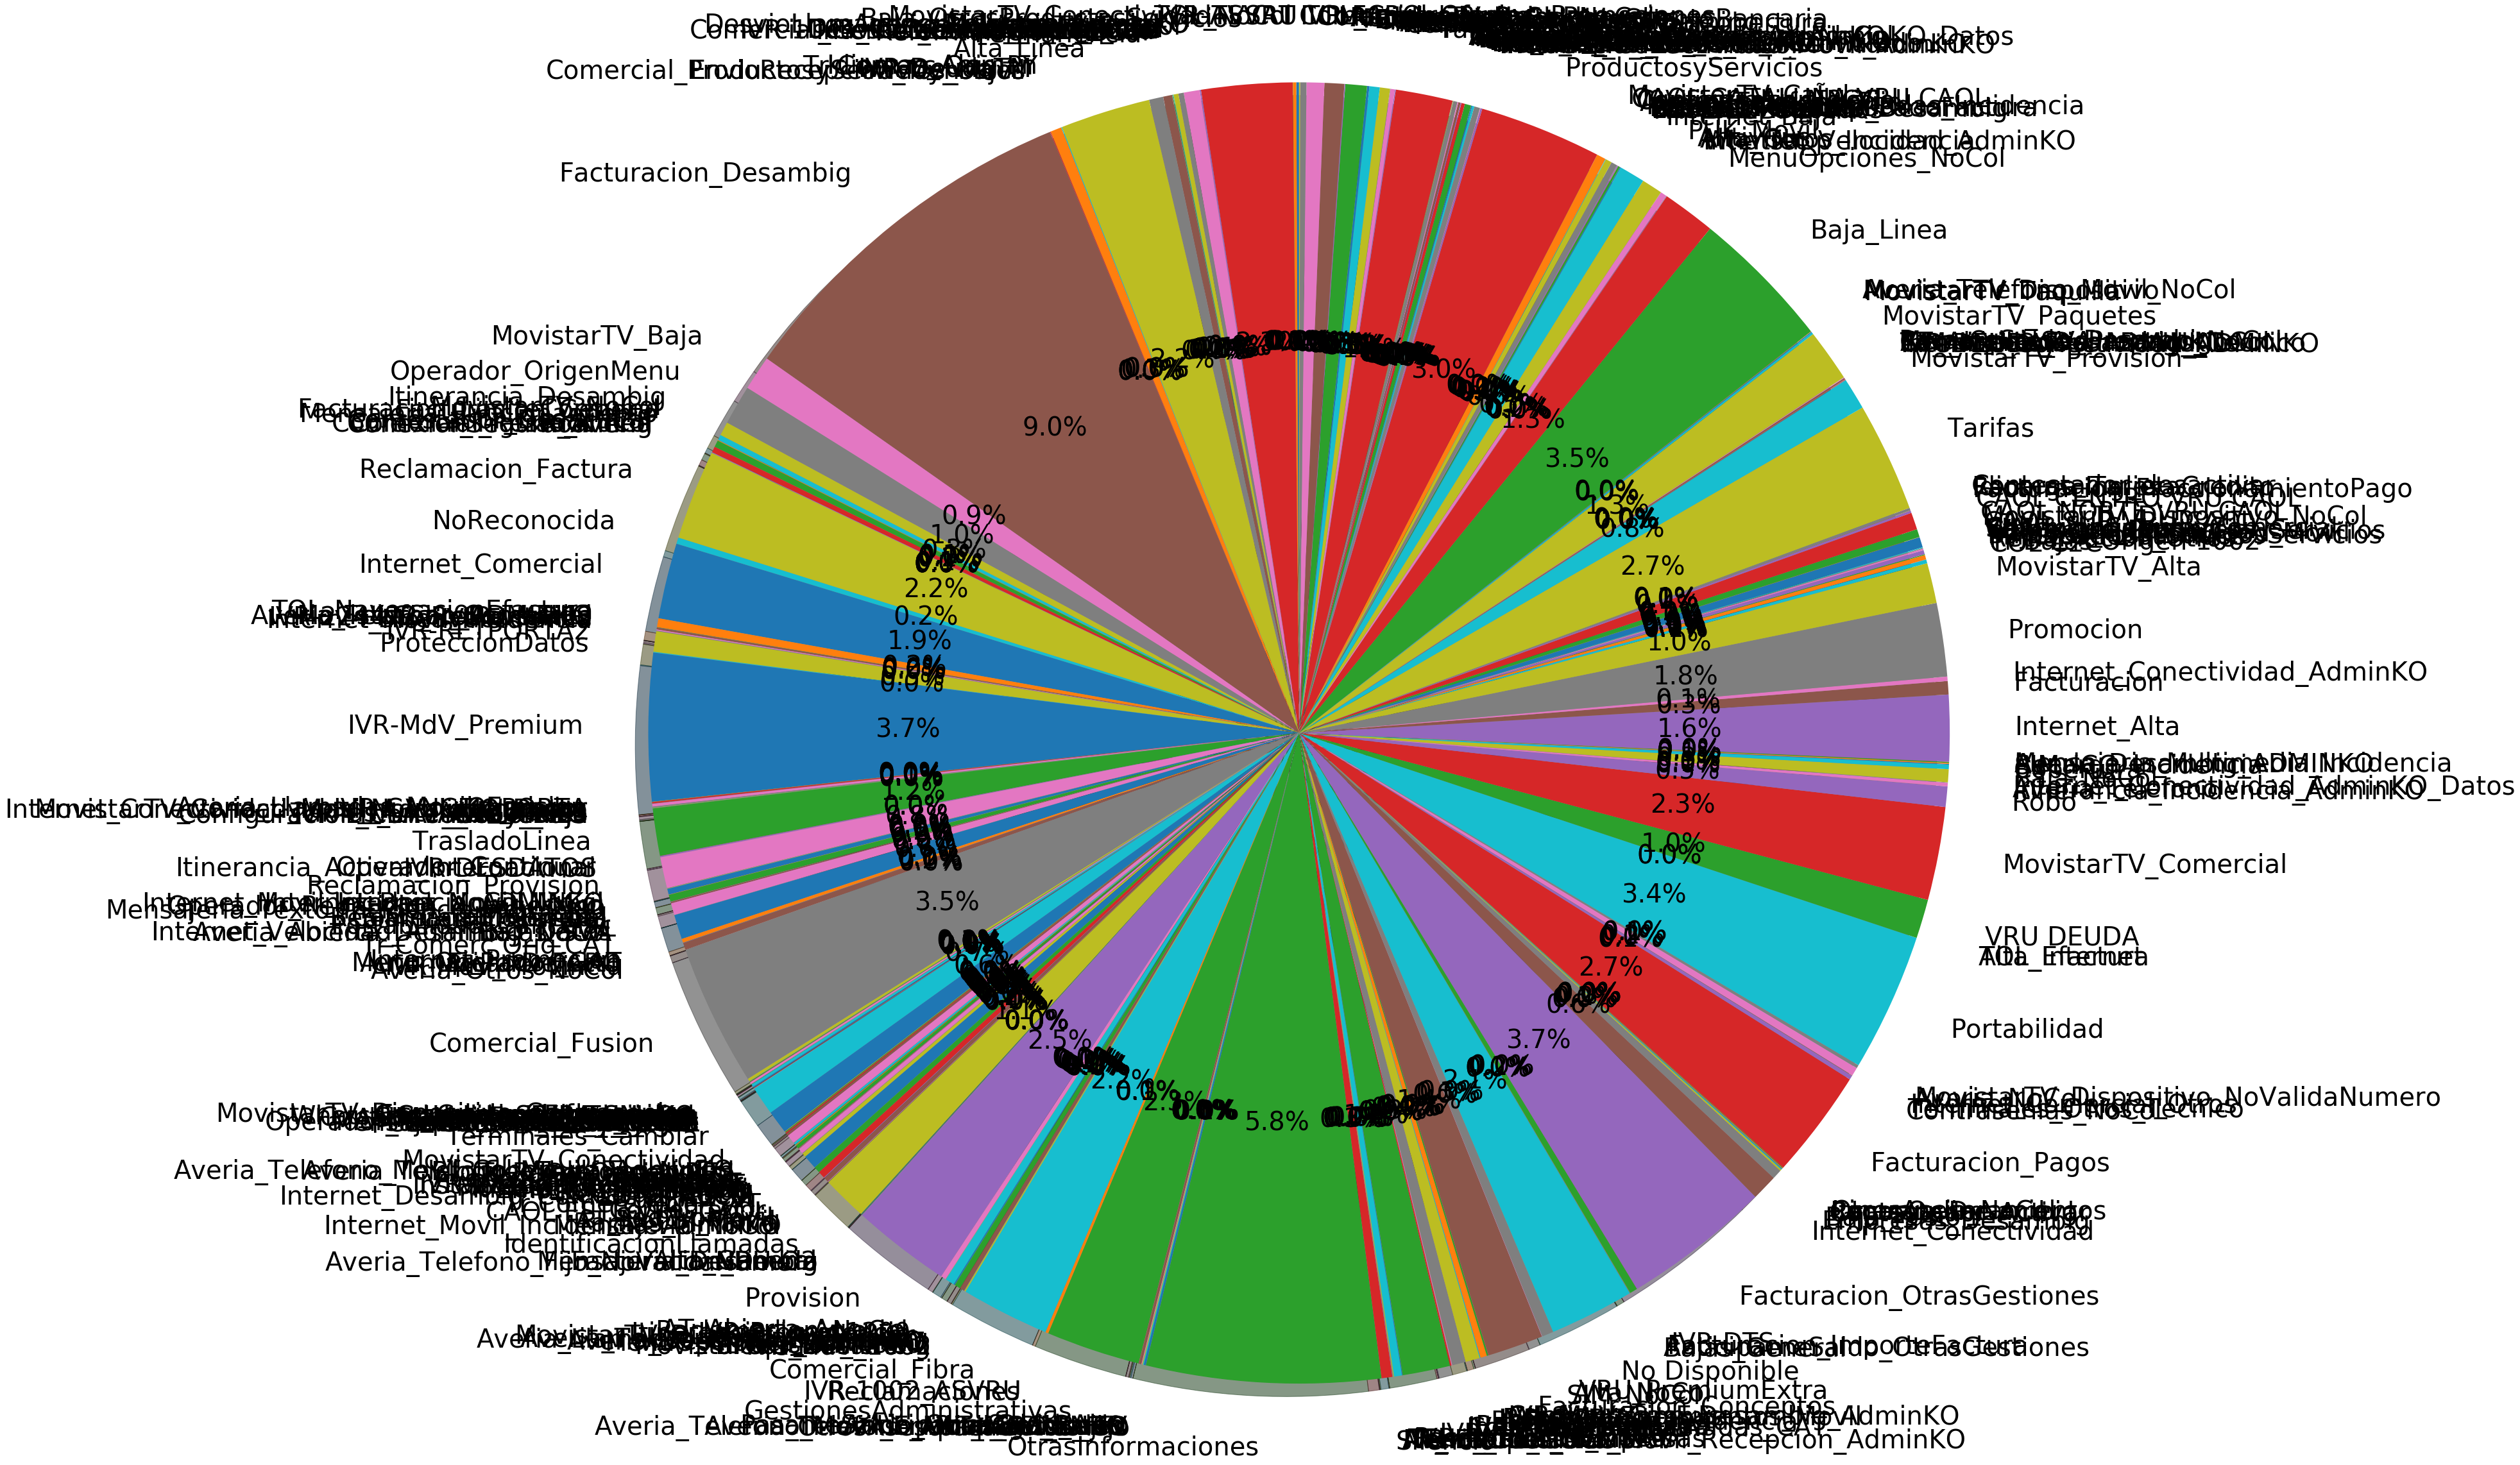

In [8]:
import matplotlib as mpl


def plot_pie(data):
    (labels, sizes) = list(zip(*data)) 
    plt.figure(figsize = (40,40))
    patches, texts, autotexts = plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontsize': 40})
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

plot_pie(label_dist)

<div style="background-color: #eeffee; border-color: #bbFFbb; border-left: 5px solid #88FF88; padding: 0.5em;">
Habría que intentar tener una jerarquía. Demasiados temas.
</div>

In [9]:
label_hierarchy = [("Bajas", ["MovistarTV_Baja","Bajas_OtrosProductosServicios","Bajas_SVA","Baja_OtrosProductosServicios","Bajas_Lineas","CRC_Bajas", "Bajas_General", "Tr Bajas Origen 1002", "Baja_Linea", "Internet_Baja", "Internet_Baja_Datos","Baja_NoCol","Tr Bajas Origen RES", "Baja_Fusion", "Bajas_Lineas", "Internet_Baja_NoCol_Movil", "YaVoy_Baja", "MovistarTV_Baja_Paquetes"] ),
                    ("Altas", ["Contratacion_Extra","Alta_Internet", "Alta_NoCol","Alta_Otros", "Comercial_Alta", "Alta_General", "Internet_Alta", "Alta_Linea", "MovistarTV_Alta"]),
                   ("Averias", ["Averia_Telefono_Movil_ADMINKO","Averia_Llamadas_Movil_Emision","Averia_Telefono_ADMINKO","Averia_Telefono_Movil_NoCol","Averia_Telefono_ADMINKO","Averia_Telefono_Movil_Recepcion","Averia_Abierta_Desambig_NoCol","Averia_Llamadas_Movil_Emision","Averia_Desambig_ADMINKO", "Averia_Desambig_ADMINKO", "Averia_RouterModem", "Averia_Telefono_Movil_Cobertura_AdminKO", "Averia_Telefono_Fijo_NoValidaNumero", "Averia_Desambig_AdminKO", "Averia_Abierta_Agente","Averia_Otros_NoCol", "Averia_Telefono_Movil_AdminKO", "Averia_Telefono_Fijo", "Averia_Telefono_Movil_Cobertura", "Averia_Telefono_Movil_Emision", "Averia_Telefono_Movil_Emision_AdminKO", "Averia_Telefono", "Averia_Ordenador", "Averia_NoCol", "Averia_Otros", "Averia_Otros_Desambig", "Averia_Telefono_Movil_Recepcion_AdminKO", "Averia_Llamadas_Movil_Recepcion", "Terminales_Averia", "Averia_Telefono_AdminKO", "ConexionSegura_Averia"]),
                   ("Incidencias",  ["YaVoy_Incidencia","Internet_Movil_Incidencia_AdminKO","DesvioLlamadas_Incidencia_AdminKO","Mensajeria_Texto_Incidencia","Emocion_Incidencia","DesvioLlamadas_Incidencia","SIM_Incidencia","Internet_Movil_Incidencia_ADMINKO","Whatsapp_Incidencia_AdminKO","Itinerancia_Incidencia_AdminKO","Itinerancia_Incidencia", "Whatsapp_Incidencia","SIM_Incidencia_AdminKO", "Mensajeria_Texto_Incidencia_AdminKO", "Recarga_Incidencia", "Internet_Movil_Incidencia_AdminKO_Datos", "IdentificacionLlamadas_Incidencia", "SIM_Incidencia_ADMINKO", "Incidencia_Movil_NoCol", "Internet_Movil_Incidencia"]),
                   ("Reclamacion", ["Reclamacion_NoCol", "Reclamacion_Otros","Reclamacion_General","Reclamacion_Factura", "Reclamaciones", "Reclamacion_Provision", "Reclamacion_Saldo", "Reclamacion_Incidencia"]),
                   ("Roaming",["Itinerancia_Gestiones","Roaming", "Itinerancia_NoCol", "Itinerancia_Activar_Roaming", "Itinerancia_Activar_Internacional", "Tarifas_Internacionales"]),
                   ("Facturacion",["Operador_Repeticion_Facturacion","Facturacion_OtrasGestiones","Facturacion_CambioCuentaBancaria","Facturacion_Deuda","Facturacion_ImporteFactura","Facturacion_DuplicadoFactura", "Facturacion_ImporteFactura", "Contestador_Facturacion","TOL_Efactura","Facturacion_Informacion","Facturacion_Conceptos","Facturacion_Desambig","Facturacion_General","Facturacion_Pagos", "Facturacion_LimiteConsumo", "Facturacion_FraccionamientoPago", "Facturacion_ConsumoAcumulado", ""]),
                   ("Portabilidad", ["IVR-1004_C2CCancelPortabMovil", "Portabilidad", "Comercial_Portabilidad", "Portabilidad_Cancelar"]),
                   ("Tarifas", ["Tarifas_Cambiar", "Tarifas_MiTarifa"]),
                   ("Comercial", ["MovistarTV_Comercial","Comercial_Fibra", "Internet_Comercial", "Internet_Comercial_Otros", "Comercial_ProductosyServicios_Movil", "Comercial_GestionesAdministrativas", "Comercial_Internet", "Comercial_Resto", "Comercial_OfertasyPromociones","Comercial_Fusion","Configuracion_Correo","Comercial_Resto_NoCol","Comercial_SVA","Comercial_TrasladoLinea","Comercial_MovistarTV" , "ComercialEmpresas", "Comercial_ProductosyServicios", "Whatsapp_Comercial", "Tr Comerc Orig CAT"]),
                   ("Informacion",["OtrasInformaciones", "Informacion", "OtrosAsesoramientos", "ProteccionDatos"]),
                   ("OtrasGestiones", ["Configuracion_Otros","Idiomas_Aleman", "Idiomas_Arabe", "Idiomas_Ingles","TrasladoLinea","AnticipameSaldo_Alta","GestionesAdministrativas","AnticipameSaldo_NoCol","PasameSaldo_OtrasGestiones", "Contestador_activar", "TOL_Contrasenia", "IdentificacionLlamadas", "PUK_Movil", "Recarga_TarjetaCredito", "Recarga_Desambig", "RestringirLlamada", "BloqueoTelefono_Desambig"]),
                   ("Provision", ["Provision_NoCol","MovistarTV_Provision", "Provision"]),
                   ("Conectividad", ["MovistarTV_ConectividadTVSAT","Internet_Conectividad_Movil_AdminKO", "Internet_Conectividad", "Internet_Conectividad_Movil", "Internet_Conectividad_AdminKO", "Internet_Conectividad_Movil_AdminKO_Datos", "Internet_Conectividad_AdminKO_Datos","MovistarTV_Conectividad", "Internet_Conectividad_ADMINKO", "MovistarTV_Conectividad_NoValidaNumero" ]), 
                   ("PremiumEmpleados", ["IVR-PA_Empleados","VRU_PremiumExtra", "IVR-MdV_Premium", "IVR-PA_Empleados", "IVR-MdV_Premium"]),
                   ("MovistarTV", ["MovistarTV_Mando", "MovistarTV_Dispositivo_NoCol", "MovistarTV_Promocion", "AT_MovistarTV", "MovistarTV_Dispositivo_NoValidaNumero","MovistarTV_NoCol", "MovistarTV_Dispositivo", "MovistarTV_Dispositivo_Contrasenias", "MovistarTV_Taquilla", "MovistarTV_Paquetes", "MovistarTV_Futbol", "MovistarTV_Catalan", "MovistarTV_Dispositivo_Activar"]),
                   ("Terminales", ["Terminales_Otros_Tecnico_NoCol","LiberarTerminal","Terminales_Otros_Tecnico","Terminales_Cambiar", "Terminales_Avanzados_Tecnico", "Terminales_Otros_Tecnico_AdminKO", "Terminales_Otros_Tecnico_NoCol"])
                   
                  ]

In [10]:


sqlContext.sql("""SELECT *
                                FROM label_tmp
        
                                WHERE no_destino_pa = 'VRU DEUDA'""").show(10, False)

+-------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [11]:


label_hier_dict = dict([(bottom, el[0])
                      for el in label_hierarchy
                      for bottom in el[1]])

#labels_top_level = list(set([label_hier_dict[l] if l in label_hier_dict else l for l in labels]))
#print("de {} en orig a {}".format(len(labels), len(labels_top_level)) )
#labels_top_level

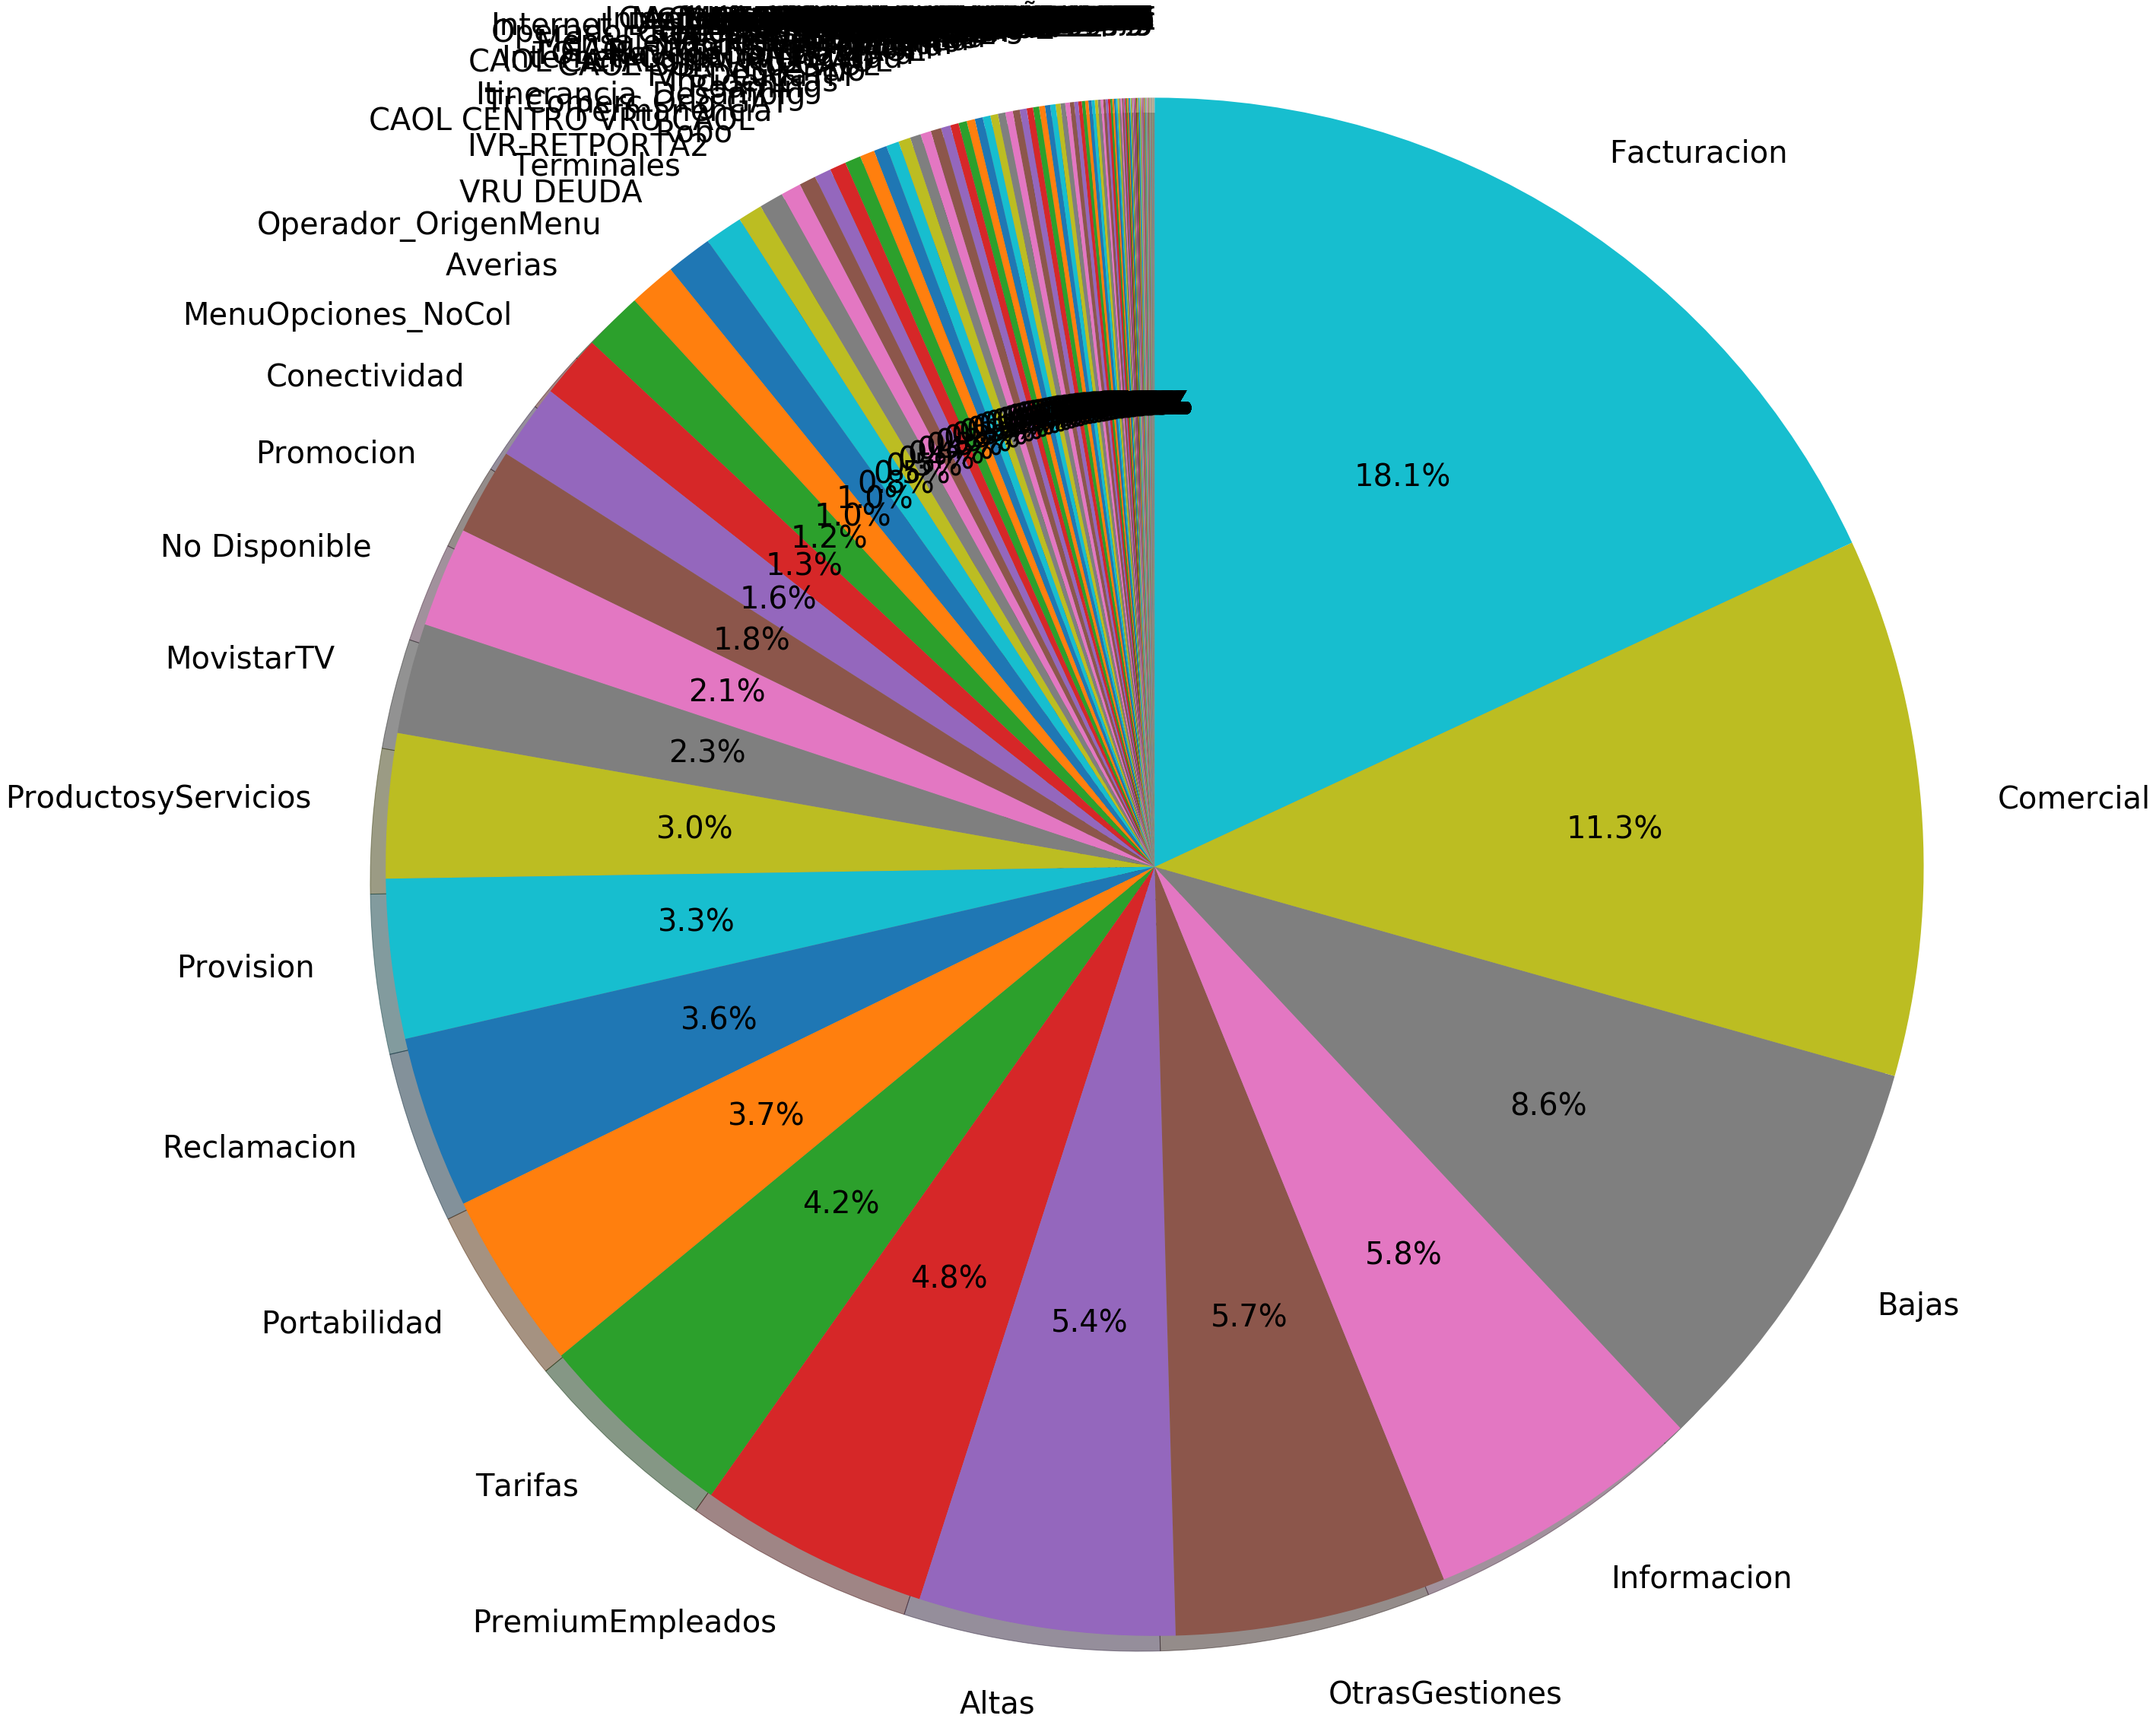

[('CobroRevertido', 1),
 ('IVR-DESDATOS', 1),
 ('IVR-TCredito', 1),
 ('MenuOpciones', 1),
 ('CAOL CATALUÑA CAOL', 1),
 ('Contestador', 1),
 ('IVR-NEWSAV7', 1),
 ('BloqueoTelefono', 1),
 ('OtrosAsesoramientos_Fijo', 1),
 ('Configuracion_Desambig_AdminKO', 1),
 ('IVR-DEUDAF', 1),
 ('223548 Repos', 1),
 ('Menu_Operador_GAT_AdminKO', 1),
 ('Menu_Operador_CAT', 1),
 ('Empresas_Voz', 1),
 ('Reformulacion_NoCol', 2),
 ('EnvioRecepcion_Mensajes', 2),
 ('EtiPorDefecto', 2),
 ('Contratacion_MasMegas', 2),
 ('IVR-FRAUDE', 2),
 ('OPERADOR', 2),
 ('PasameSaldo_NoCol', 2),
 ('IVR-PAGOTARJETA', 2),
 ('Conexion_Segura', 2),
 ('Empresas_Desambig', 2),
 ('MovistarCar_Comercial', 3),
 ('ConexionSegura_NoCol', 3),
 ('AT_Abierta_Agente', 3),
 ('Configuracion_NoCol', 3),
 ('Internet_NoCol_AdminKO', 3),
 ('Configuracion_Correo_AdminKO', 4),
 ('IVR-LINEAVACACIONES', 4),
 ('Asesoramiento_MWI', 4),
 ('MenuOpciones_AdminKO', 4),
 ('IVR-DTS', 4),
 ('PasameSaldo_Desambig', 4),
 ('Antivirus', 5),
 ('Automarcador FA

In [12]:
reduce_dict = defaultdict(int)

label_dist_top_no_group = [(label_hier_dict[l[0]], l[1]) if l[0] in label_hier_dict else (l[0], l[1])  for l in label_dist]
for l in label_dist_top_no_group:
    reduce_dict[l[0]] = reduce_dict[l[0]] + l[1]
label_dist_top =  sorted(list(reduce_dict.items()), key=lambda x:x[1])


plot_pie(label_dist_top)
label_dist_top

In [13]:

label_hier_dict_bc =  sc.broadcast(label_hier_dict)
category_calls = label_calls.rdd.map(lambda x: 
                    (x["co_llamada_verint"], x["raw_verint"],x["no_destino_pa"], 
                     label_hier_dict_bc.value[x["no_destino_pa"]] if x["no_destino_pa"] in label_hier_dict_bc.value else x["no_destino_pa"]) 
                               ).toDF(["co_llamada_verint","raw_verint",  "no_destino_pa", "category"])


category_calls.cache()
category_calls.count()



170844

In [95]:
#category_calls.filter(category_calls["category"] == "Facturacion").select(["raw_verint"]).show(5, False)



#category_calls.filter(category_calls["category"] == "Facturacion").select(["raw_verint"]).rdd.map(list).take(1)

aux = category_calls.filter(category_calls["category"] == "Facturacion").select(["raw_verint"]).rdd.map(list)


In [87]:


def unpack_list(x): 
    y=x
    while(isinstance(y, list)):
        if (len(y) > 0):
            if (isinstance(y[0], list)):
                y = [item for sublist in y for item in sublist]
            else:
                return " ".join(y)
        else:
            return None
                


def get_tokens(calls): 
    #uno las llamadas primero que se queden siempre como una lista
    raw_calls = calls.map(unpack_list)
    StopWords = stopwords.words("spanish")
    raw_no_stop = raw_calls.map( lambda document: document.strip().lower()) \
    .map( lambda document: re.split(" ", document)) \
    .map( lambda word: [x for x in word if x not in StopWords])
    return raw_no_stop
    
    
def get_tokens_stemmed_no_gen(calls, stem_dict, gen):
    #uno las llamadas primero que se queden siempre como una lista
    raw_calls = calls.map(lambda x: [unpack_list(x[0]), x[1]] )
    StopWords = stopwords.words("spanish")
    raw_no_stop = raw_calls.map( lambda document: [document[0].strip().lower(), document[1]]) \
    .map( lambda document: [re.split(" ", document[0]), document[1]]  ) \
    .map( lambda document: [[stem_dict[x][1] for x in document[0] if x not in StopWords and x in stem_dict and stem_dict[x][1] not in gen], document[1]])
    return raw_no_stop 
    
    

In [58]:
tokens = get_tokens(category_calls.
           select(["raw_verint"]).rdd.map(list))
tokens_count = tokens.flatMap(lambda x: x).map(lambda x: (x, 1)).reduceByKey(lambda a,b: a+b)
tokens_count.cache()
tokens_count.count()
tokens_count_list = tokens_count.collect()

Tokens generales por orden

In [17]:
sorted(tokens_count_list, key=lambda x: x[1], reverse=True)

[('-', 2069134),
 ('vale', 1951894),
 ('si', 1774180),
 ('usted', 914814),
 ('pues', 867911),
 ('dos', 698462),
 ('ver', 664338),
 ('entonces', 639129),
 ('cinco', 541851),
 ('línea', 522245),
 ('seis', 518786),
 ('momento', 474175),
 ('bueno', 471988),
 ('movistar', 437218),
 ('cuatro', 417281),
 ('tres', 416601),
 ('ahora', 416329),
 ('móvil', 410073),
 ('euros', 409092),
 ('favor', 398034),
 ('vamos', 395305),
 ('ocho', 375244),
 ('número', 362111),
 ('nueve', 359849),
 ('gracias', 359675),
 ('acuerdo', 359209),
 ('cero', 352259),
 ('siete', 334369),
 ('bien', 332813),
 ('claro', 330270),
 ('teléfono', 328269),
 ('hacer', 319280),
 ('voy', 317725),
 ('puede', 316054),
 ('factura', 314894),
 ('días', 297315),
 ('puedo', 294767),
 ('día', 285903),
 ('treinta', 282250),
 ('va', 276679),
 ('nombre', 272332),
 ('fusión', 258803),
 ('aquí', 258796),
 ('baja', 244900),
 ('mismo', 227498),
 ('cuarenta', 226176),
 ('quiere', 208778),
 ('ciento', 202553),
 ('cincuenta', 201113),
 ('mes', 1989

Quiero probar con el stem y si acaso eetiqueto

<div style="background-color: #eeffee; border-color: #bbFFbb; border-left: 5px solid #88FF88; padding: 0.5em;">
En tags dict almaceno todo el vocabulario etiquetado 'informado': ('VLadj', 'informar')
    </div>

In [30]:
tagger = treetaggerwrapper.TreeTagger(TAGLANG='es', TAGPARFILE="/tmp/tree/spanish.par", TAGDIR="/tmp/tree/tree-tagger-3.2.1/")


vocabulary =  tokens_count\
    .map(lambda tuple: tuple[0]) 

vocabulary_tags = list(map(lambda el: (el[0], (el[1], el[2]) ) ,map(lambda y: y.split("\t"),list(tagger.tag_text((" ".join(vocabulary.collect())) )))))
tags_dict = sc.broadcast({key: value for (key, value) in vocabulary_tags})


<div style="background-color: #eeffee; border-color: #bbFFbb; border-left: 5px solid #88FF88; padding: 0.5em;">

Con el stemed ordeno las palabras más usadas

</div>

In [32]:

stem_tokens = tokens.flatMap(lambda x: x).\
            filter(lambda token: token in tags_dict.value).\
            map(lambda token: tags_dict.value[token][1])

stem_tokens_count = stem_tokens.\
        map(lambda token: (token ,1)).\
        reduceByKey(lambda a,b: a+b)
stem_tokens_count_list = sorted(stem_tokens_count.collect(), key=lambda x: x[1], reverse=True)



In [22]:
stem_tokens_count_list[:]

[('-', 2069134),
 ('valer', 1955875),
 ('si', 1774180),
 ('ir', 1227397),
 ('decir', 1023500),
 ('poder', 1005289),
 ('bueno', 915890),
 ('usted', 914814),
 ('hacer', 880813),
 ('pues', 870014),
 ('ver', 843764),
 ('línea', 729841),
 ('dos', 698462),
 ('entonces', 639129),
 ('querer', 590766),
 ('día', 584495),
 ('momento', 556227),
 ('llamar', 553268),
 ('cinco', 541851),
 ('móvil', 524771),
 ('seis', 518786),
 ('movistar', 437218),
 ('ahora', 422597),
 ('euro', 421103),
 ('cuatro', 417865),
 ('tres', 416601),
 ('número', 401998),
 ('favor', 398050),
 ('llamada', 395070),
 ('dar', 377576),
 ('ocho', 375484),
 ('factura', 366938),
 ('gracia', 363414),
 ('nueve', 359849),
 ('acuerdo', 359324),
 ('cero', 354768),
 ('teléfono', 343344),
 ('claro', 335305),
 ('siete', 334373),
 ('bien', 332910),
 ('mes', 325335),
 ('pasar', 324748),
 ('pagar', 302701),
 ('poner', 302600),
 ('fijo', 290744),
 ('treinta', 282250),
 ('mismo', 280831),
 ('nombre', 273442),
 ('ciento', 271094),
 ('bajo', 261320

<div style="background-color: #eeffee; border-color: #bbFFbb; border-left: 5px solid #88FF88; padding: 0.5em;">
términos muy generales que no tendré en cuenta, aparecen mucho, pero dejo algunos términos que me parecen significativos
</div>

In [96]:
general_terms = list(map(lambda x: x[0] ,filter(lambda x: x[1] > 10000 and x[0] not in ["factura", "servicio", "fijo", "paquete", "internet"] , stem_tokens_count_list  )))

In [50]:
general_terms[:10]

['-', 'valer', 'si', 'ir', 'decir', 'poder', 'bueno', 'usted', 'hacer', 'pues']

In [90]:
tokens_gen = get_tokens(category_calls.
           select(["raw_verint", "category"]).rdd.map(list))
#stemmed_tokens = tokens_gen.filter(lambda token: token in tags_dict.value).\
#            map(lambda token: tags_dict.value[token][1])
#stemmed_tokens.take(1)

<div style="background-color: #eeffee; border-color: #bbFFbb; border-left: 5px solid #88FF88; padding: 0.5em;">
Tenemos los tokens sttemed sin los términos generales y categorizados
</div>

In [97]:
#tokens_stemmed_no_gen  = get_tokens_stemmed_no_gen(tokens_gen, tags_dict.value,general_terms)

tokens_stemmed_no_gen = get_tokens_stemmed_no_gen(category_calls.\
           select(["raw_verint", "category"]).rdd.map(list),  tags_dict.value,general_terms)
tokens_stemmed_no_gen.cache()
tokens_stemmed_no_gen.count()

170844

<div style="background-color: #eeffee; border-color: #bbFFbb; border-left: 5px solid #88FF88; padding: 0.5em;">
Creamos nube de palabras con todos los términos stemmed</div>

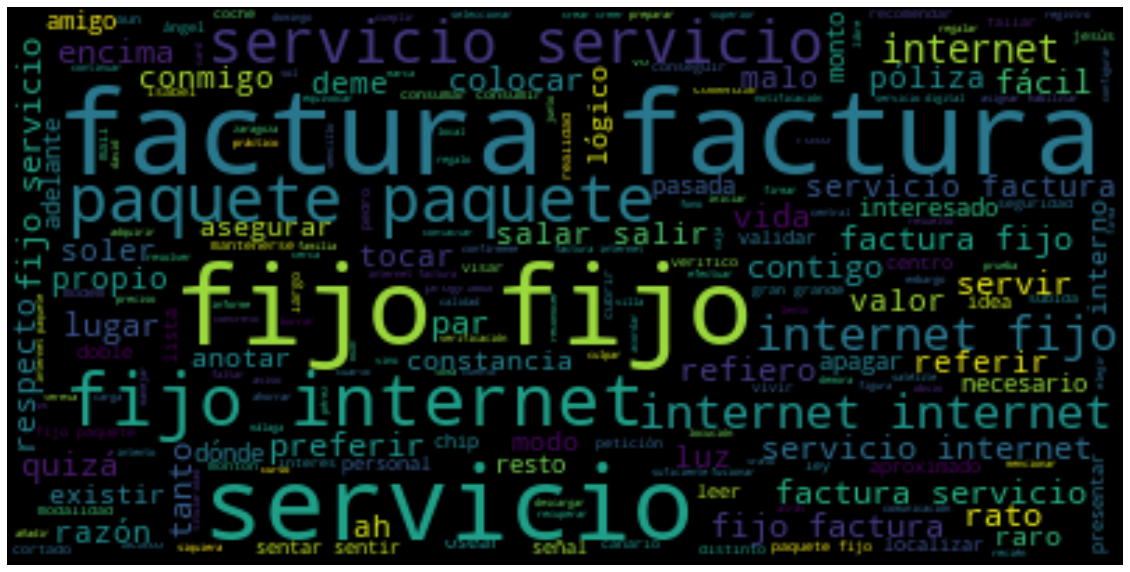

In [98]:
list_words = tokens_stemmed_no_gen.map(lambda x: " ".join(x[0])).reduce(lambda x, y: x + y)

wordcloud = WordCloud().generate(list_words)

# Display the generated image:
plt.figure(figsize = (20,20))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

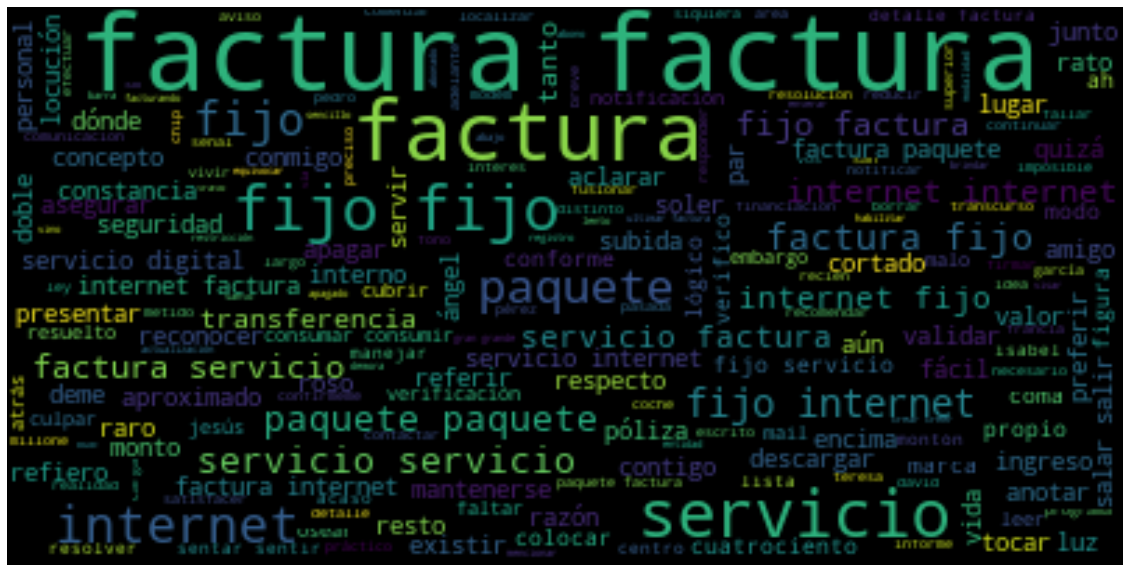

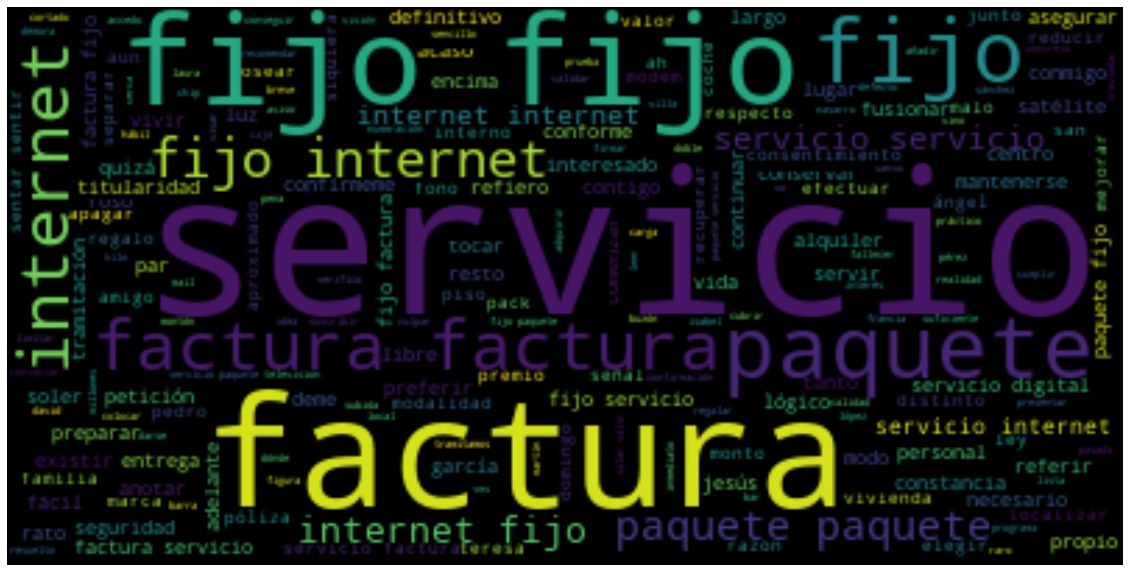

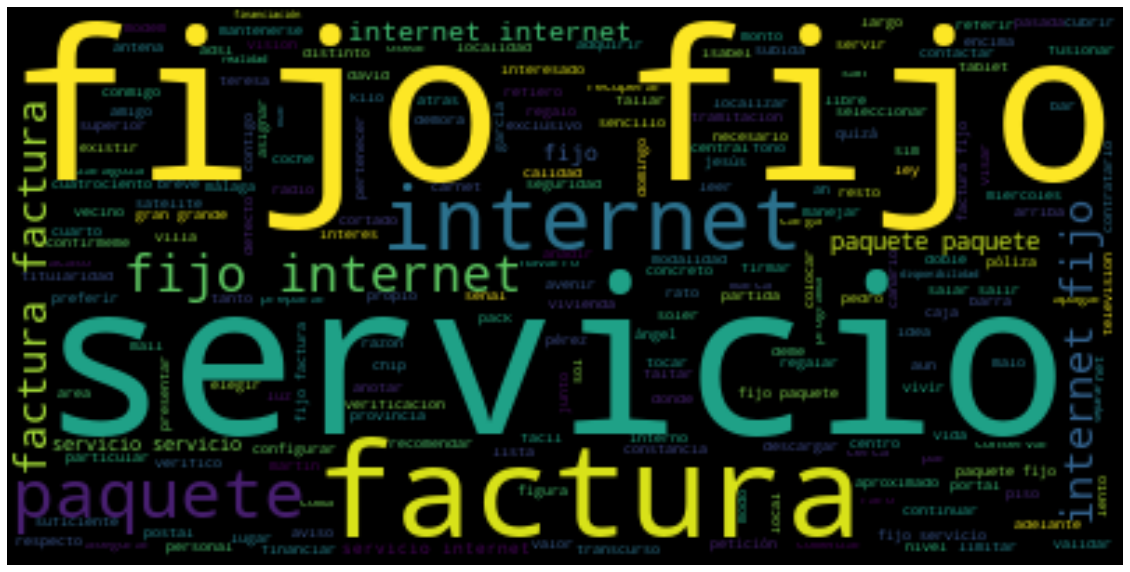

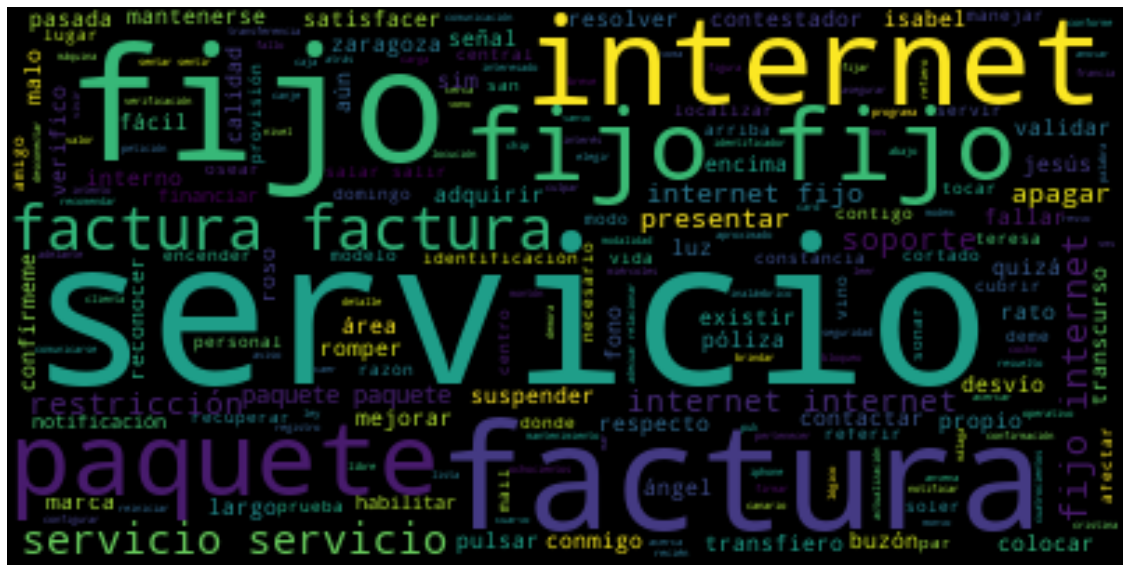

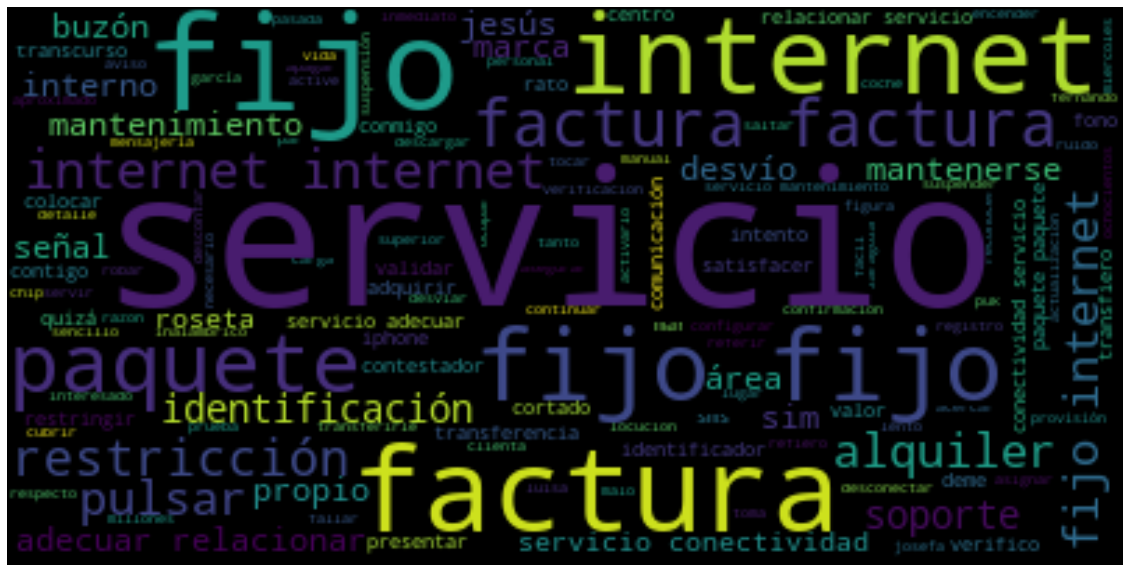

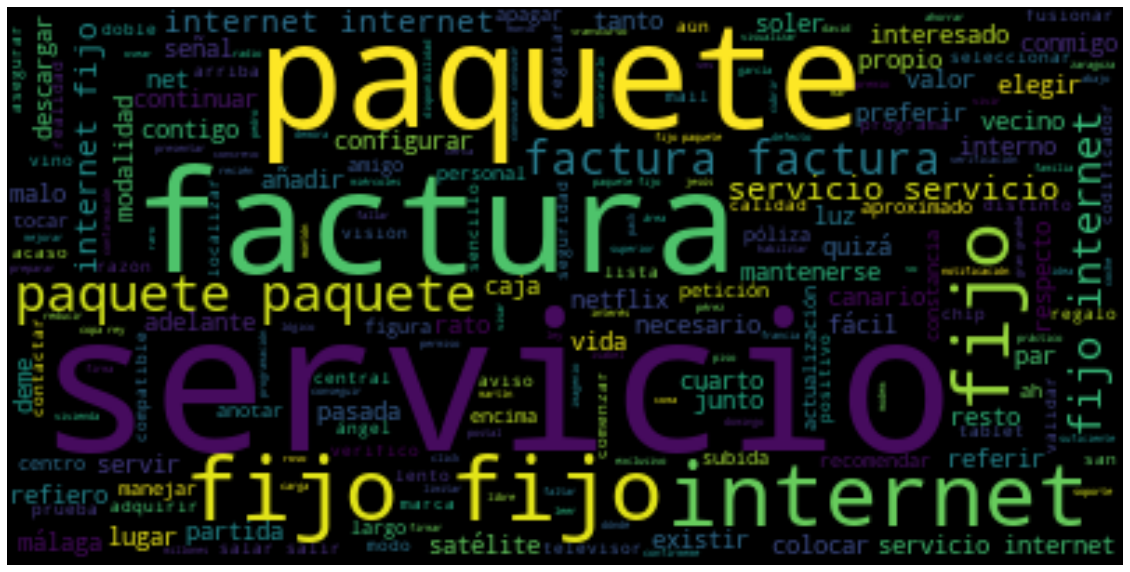

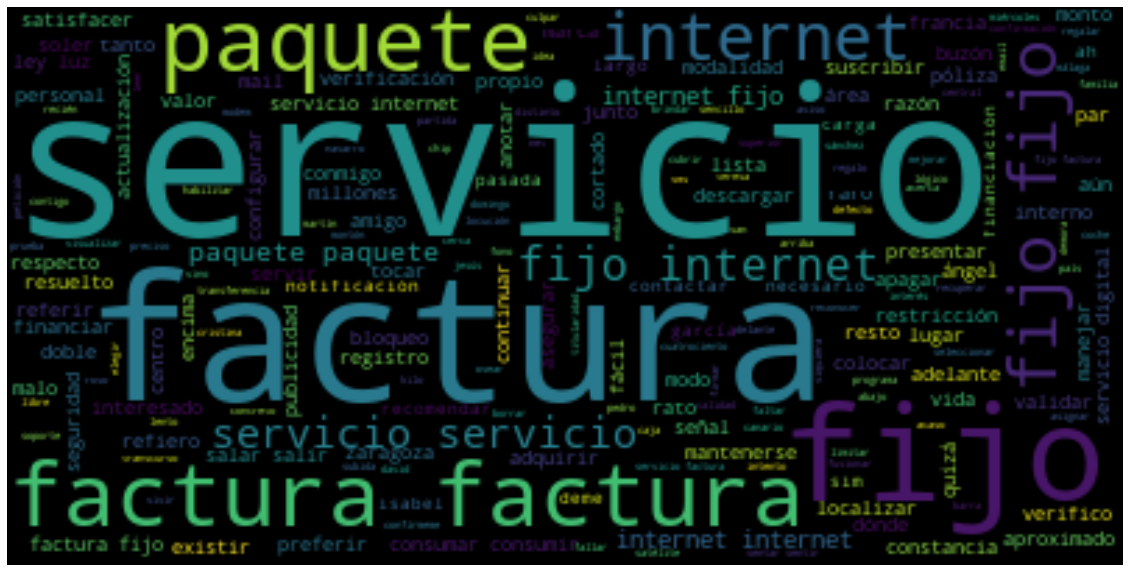

In [99]:
categorias = ["Facturacion","Bajas", "Altas", "Averias", "Incidencias", "Comercial", "Informacion"]

for c in categorias: 
    list_words = tokens_stemmed_no_gen.filter(lambda x: x[1] == c).map(lambda x: " ".join(x[0])).reduce(lambda x, y: x + y)
    wordcloud = WordCloud().generate(list_words)
    # Display the generated image:
    plt.figure(figsize = (20,20))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    

In [26]:
list_words

PythonRDD[126] at RDD at PythonRDD.scala:52

<div style="background-color: #eeffee; border-color: #bbFFbb; border-left: 5px solid #88FF88; padding: 0.5em;">
Categoria de facturación con todos los términos</div>

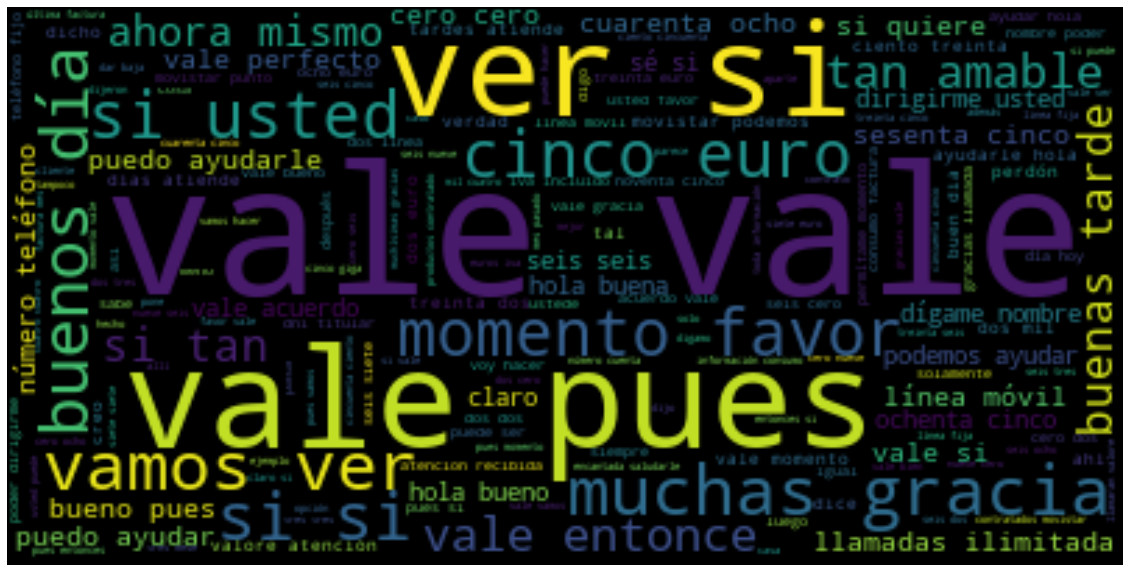

In [28]:
tokens_fact = get_tokens(category_calls.filter(category_calls["category"] == "Facturacion").
           select(["raw_verint"]).rdd.map(list))

list_words = tokens_fact.map(lambda x: " ".join(x)).reduce(lambda x, y: x + y)

wordcloud = WordCloud().generate(list_words)

# Display the generated image:
plt.figure(figsize = (20,20))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


<div style="background-color: #eeffee; border-color: #bbFFbb; border-left: 5px solid #88FF88; padding: 0.5em;">
LDA.
    
 Empezamos contando términos
</div>

In [113]:
 tokens_stemmed_no_gen.map(lambda x: x[0]).zipWithIndex().take(1)

[(['servicio',
   'retires',
   'navarro',
   'arroba',
   'hotmail',
   'com',
   'espada',
   'módulo',
   'temperatura',
   'peri',
   'fijo',
   'pico',
   'servicio',
   'servicio',
   'reactivar',
   'momentillo',
   'brindar',
   'primo',
   'soler',
   'lograr',
   'paradito',
   'lograr',
   'efecto'],
  0)]

In [114]:
tokens_lda = tokens_stemmed_no_gen.map(lambda x: x[0]).zipWithIndex()

termCounts_tokens =  tokens_lda.filter(lambda x: len(x)>0) \
    .flatMap(lambda document: document[0]) \
    .map(lambda word: (word, 1)) \
    .reduceByKey( lambda x,y: x + y)   \
    .map(lambda tuple: (tuple[1], tuple[0]))  \
    .sortByKey(False)

<div style="background-color: #eeffee; border-color: #bbFFbb; border-left: 5px solid #88FF88; padding: 0.5em;">
Extraemos el vocabulario. 
</div>

In [126]:
###umbral
threshold_value =5000 
vocabulary_tokens = termCounts_tokens   \
  .filter(lambda x : x[0] < threshold_value)  \
  .map(lambda x: x[1])  \
  .zipWithIndex()  \
  .collectAsMap()
vocab_size_tokens = len(vocabulary_tokens)

<div style="background-color: #eeffee; border-color: #bbFFbb; border-left: 5px solid #88FF88; padding: 0.5em;">
creamos el dataframe necesario para aplicar LDA. 
</div>

In [117]:
from pyspark.ml.feature import CountVectorizer , IDF
from pyspark.ml.clustering import LDA

In [127]:
df_txts = sqlContext.createDataFrame(tokens_lda, ["list_of_words",'index'])
cv = CountVectorizer(inputCol="list_of_words", outputCol="features", vocabSize=vocab_size_tokens, minDF=10.0)
cvmodel = cv.fit(df_txts)
result_cv = cvmodel.transform(df_txts)
lda_df = result_cv[['index', 'features']]

<div style="background-color: #eeffee; border-color: #bbFFbb; border-left: 5px solid #88FF88; padding: 0.5em;">
Aplicamos LDA
</div>

In [128]:
num_topics=4
max_iterations = 50
lda_tokens = LDA(k=num_topics, maxIter=max_iterations)
model_tokens =lda_tokens.fit(lda_df)

In [130]:
topics = model_tokens.describeTopics()


In [131]:
terms_tokens = dict([(value, key) for key, value in vocabulary_tokens.items()])
topics_term = topics.rdd.map(lambda x: [x[0],list(map(lambda y: terms_tokens[y],x[1])), x[2]])
topics_term.toDF(["t1", "t2"])["t1", "t2"].show(truncate=False)

+---+---------------------------------------------------------------------------------------------+
|t1 |t2                                                                                           |
+---+---------------------------------------------------------------------------------------------+
|0  |[positivo, suspensión, q, pena, suficiente, quizá, ahorrar, plataforma, calificar, dinamarca]|
|1  |[suficiente, pena, positivo, q, derecho, práctico, adsl, imposible, marta, palabra]          |
|2  |[pena, vecino, aclarar, emplear, pendiente, eliminar, numeración, módulo, Portales, q]       |
|3  |[toledo, suficiente, ocasionar, acordar, positivo, contento, ocupar, requerir, pena, toca]   |
+---+---------------------------------------------------------------------------------------------+

